In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import chardet
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer

# Word Stemming
from nltk.stem.porter import PorterStemmer

# Word Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# División estratificada
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Descargas de nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Crear una instancia del WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Crear una instancia del Porter Stemmer
stemmer = PorterStemmer()

# Crear una instancia del tokenizador
tokenizer = WhitespaceTokenizer()

# Lista de stopwords en ingles
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [51]:
# Leer el archivo con la codificacion detectada
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]
df = df.rename(columns={'v1': 'tipo', 'v2': 'mensaje'})

In [52]:
# Funcion para mapeo de POS a primer caracter
def get_wordnet_pos(word, tag):
    """Map POS tag to the first character lemmatize() accepts"""
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag[0].upper(), wordnet.NOUN)

### Análisis de datos exploratorio (EDA)

- En esta fase se definieron características estadísticas relevantes del conjunto de datos proporcionado, con el objetivo de diferenciar los grupos de spam/ham y obtener conclusiones empíricas al respecto.

Cantidad de spam y ham

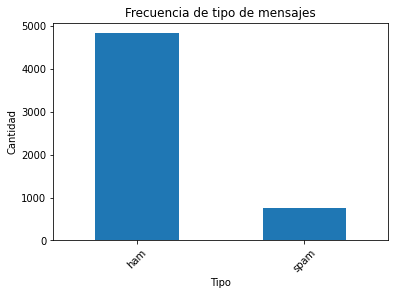

In [53]:
ax = df['tipo'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

- Existe mayor cantidad de mensajes tipo ham que mensajes tipo spam.

Cantidad de palabras en spam y ham

In [54]:
tokenizer = WhitespaceTokenizer()
df['palabras'] = df['mensaje'].apply(lambda x: tokenizer.tokenize(x))
df['cantidad'] = df['palabras'].apply(lambda x: len(x))

,count,mean,std,min,25%,50%,75%,max
tipo,,,,,,,,
ham,4825.0,14.200622,11.424511,1.0,7.0,11.0,19.0,171.0
spam,747.0,23.851406,5.811898,2.0,22.0,25.0,28.0,35.0


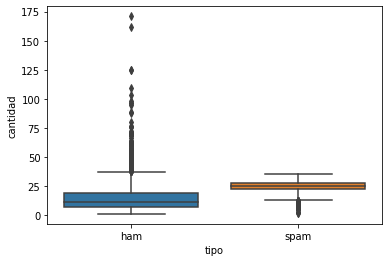

In [55]:
sns.boxplot(x='tipo', y='cantidad', data=df)
df.groupby(['tipo'])['cantidad'].describe()

- En promedio, los mensajes tipo spam son más largos que los mensajes tipo ham.
- Los mensajes tipo ham presentan mayor dispersión respecto a la media, por lo que
las longitudes de los mensajes pueden variar mucho más como es posible visualizar en el gráfico Boxplot correspondiente.

Conjunto de entrenamiento y prueba

In [57]:
train, test = train_test_split(df.copy(), test_size=0.20, stratify=df['tipo'], random_state=42)

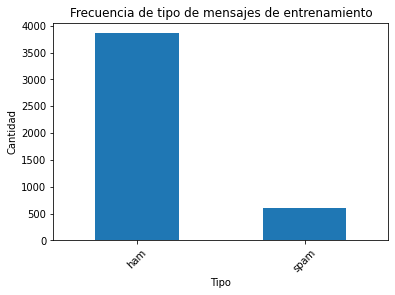

In [58]:
ax = train['tipo'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes de entrenamiento')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

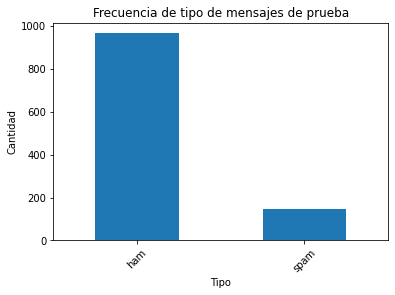

In [59]:
ax = test['tipo'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes de prueba')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

- Se observa que tanto el conjunto de entrenamiento como el conjunto de prueba mantienen la misma proporción de mensajes spam/ham

### Limpieza de datos

- En esta fase se definieron funciones con el objetivo de estandarizar las palabras y filtrar aquellas con un valor relevante para el modelo a generar.

Conversión a letras minúsculas

In [60]:
def lowerTexts(texts):
    return [text.lower() for text in texts]

- Conversión a letras minúsculas con el objetivo de realizar un modelo case insensitive.

Tokenización de los textos

In [61]:
def tokenizeTexts(texts):
    return [word_tokenize(text) for text in texts]

- Tokenización del texto utilizando word_tokenize, con el objetivo de separar las palabras de los textos.

Eliminando tokens con signos de puntuación

In [62]:
def cleanPunctuationTexts(texts):
    return [[token for token in text if not re.search(r'\W+', token)] for text in texts]

Eliminando tokens con números

In [63]:
def cleanNumberTexts(texts):
    return [[token for token in text if not re.search(r'[0-9]+', token)] for text in texts]

Eliminando stopwords

In [64]:
def cleanStopWordTexts(texts):
    return [[token for token in text if token not in stop_words] for text in texts]

- Eliminación de tokens clasificados como stopwords, es decir, palabras con poco valor para el modelo (preposiciones, artículos, etc.)

Lemmmatization

In [65]:
def lemmatizeTexts(texts):
    values = [nltk.pos_tag(text) for text in texts]
    return [[lemmatizer.lemmatize(item[0], get_wordnet_pos(item[0], item[1])) for item in value] for value in values]

- Estandarización de las palabras a través del algoritmo de Lemmatization. Esto con el objetivo de llevar las palabras a su forma base, realizando un análisis morfológico sobre cada palabra.

Stemming

In [66]:
def stemTexts(texts):
    return  [[stemmer.stem(token) for token in text] for text in texts]

- Estandarización de las palabras a través de algoritmo de Stemming. Puesto que este únicamente corta las terminaciones de las palabras, se utilizó posteriormente a la Lemmatization.

In [67]:
functions = [lowerTexts,tokenizeTexts,cleanPunctuationTexts,cleanNumberTexts,cleanStopWordTexts,lemmatizeTexts,stemTexts]

def textsProcessing(texts):
    for func in functions:
        texts = func(texts)

    return texts
    
texts = textsProcessing(train['mensaje'].tolist())

In [68]:
# Reemplazando la columna v2 por los valores obtenidos tras la limpieza
train['mensaje'] = texts

### Modelo

- En esta fase se definieron las probabilidades necesarias en base al conjunto de entrenamiento, con el objetivo de generar un modelo capaz de predecir si un texto es spam o ham a través de una red bayesiana.

Construcción de los diccionarios

In [70]:
#Diccionarios para ham y spam
ham_words = {}
spam_words = {}

# Función para actualizar el diccionario de conteos
def update_word_count(word_list, word_dict):
    for word in word_list:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

# Iterar sobre el DataFrame y actualizar los diccionarios según la categoría
for _, row in train.iterrows():
    if row['tipo'] == 'ham':
        update_word_count(row['mensaje'], ham_words)
    elif row['tipo'] == 'spam':
        update_word_count(row['mensaje'], spam_words)


- Estos diccionarios contienen los conteos necesarios para obtener las probabilidades que el modelo utilizará posteriormente.

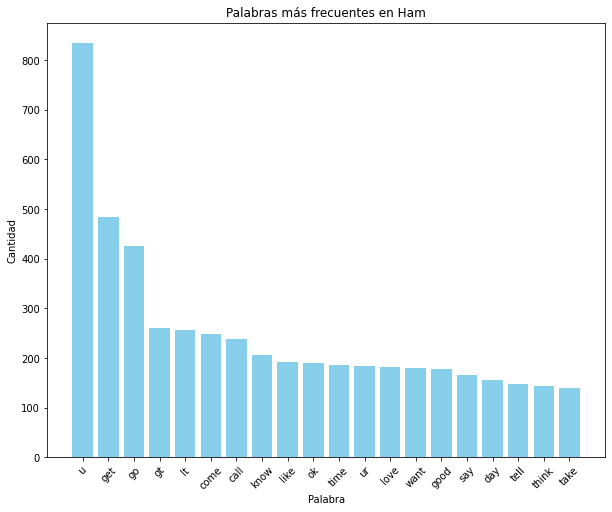

In [88]:
sorted_ham_words = sorted(ham_words.items(), key=lambda item: item[1], reverse=True)[:20]
words, counts = zip(*sorted_ham_words)  # Desempaquetar en listas separadas

# Crear la gráfica de barras
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Palabras más frecuentes en Ham')
plt.xlabel('Palabra')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

- Palabras más comúnes en el diccionario de ham.

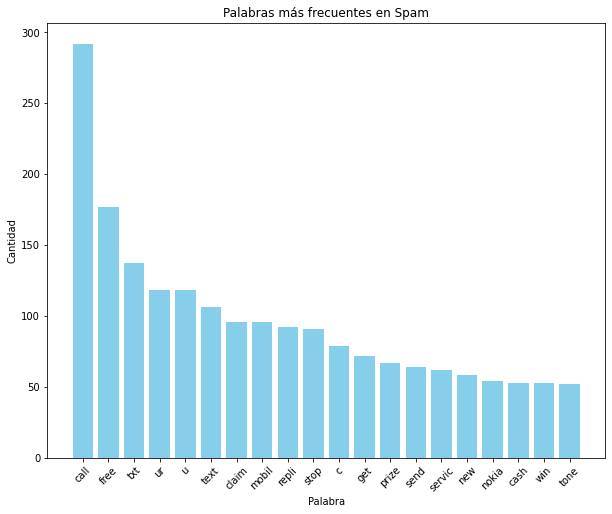

In [89]:
sorted_spam_words = sorted(spam_words.items(), key=lambda item: item[1], reverse=True)[:20]
words, counts = zip(*sorted_spam_words)  # Desempaquetar en listas separadas

# Crear la gráfica de barras
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Palabras más frecuentes en Spam')
plt.xlabel('Palabra')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

- Palabras más comúnes en el diccinario de spam.

Probabilidades

Probabilidad de Spam dado una palabra específica

In [152]:
cant_h, cant_s = train['tipo'].value_counts().tolist()
cant_total = cant_h+cant_s

# P(S), P(H)
p_h = cant_h/cant_total
p_s = cant_s/cant_total

total_words_in_spam = sum(spam_words.values())
total_words_in_ham = sum(ham_words.values())

# Funcion P(S|W)
def p_s_w(word):
    # P(W|S)
    p_w_s = spam_words.get(word,0) / total_words_in_spam

    # P(W|H)
    p_w_h = ham_words.get(word,0) / total_words_in_ham

    # P(W|S) * P(S)
    numerator = p_w_s * p_s

    # [P(W|S) * P(S)] + [P(W|H) * P(H)]
    denominator = numerator + (p_w_h * p_h)

    return numerator / denominator if denominator != 0 else 0

Probabilidad total de Spam (considerando todas las palabras identificadas)

In [153]:
# Modelo de prediccion
def modelo(probs):
    
    numerator = 1
    denominator = 1

    for prob in probs:
        numerator*=prob
        denominator*=(1-prob)

    denominator = numerator+denominator

    # Probabilidad de que el texto sea SPAM segun las palabras identificadas
    return numerator / denominator if denominator != 0 else 0

Funcion para reconocimiento de palabras en spam o en ham según el conjunto de entrenamiento.

In [129]:
# Funcion para filtrar palabras reconocidas en texto
def filterText(text):
    return [word for word in text if word in spam_words or word in ham_words]

Función para realizar la predicción sobre un texto.

In [122]:
def textPrediction(text,result):
    # Filtrado de palabras
    text = filterText(text)
    decimals = 4

    if len(set(text))>0:
        # Listado de probabilidades de todas las palabras identificadas
        probs = [p_s_w(word) for word in text]
        res = ""

        for i in range(len(text)):
            res+=text[i]+" : "+str(round(probs[i],decimals))+","

        result["Palabras reconocidas"] = res[:-1]
        total = modelo(probs)

        result ["Probabilidad total de SPAM"] = str(round(total,decimals))

        res += "Prediccion: "
        if total>0.5:
            result["Prediccion"] = "spam"
        else:
            result["Prediccion"] = "ham"
    else:
        result["Palabras reconocidas"] = "No se han reconocido palabras."

    return result


### Pruebas de rendimiento

- En esta fase se realizaron pruebas de predicción sobre el conjunto de prueba definido anteriormente.

Funcion de Prueba de Predicción. Tiene por parámetros la categoría del texto y el texto como tal.

In [123]:
def prediction(category,text):
    result = dict()
    result["Categoria"] = category
    result["Texto"] = text

    test_text = textsProcessing([text])[0]

    result = textPrediction(test_text,result)

    return result


Resultados de predicciones sobre el conjunto de prueba.

In [154]:
test_values = []
pred_values = []

for _, row in test.iterrows():
    
    result = prediction(row['tipo'],row['mensaje'])

    if "Prediccion" in result:
        test_values.append(result["Categoria"])
        pred_values.append(result["Prediccion"])
        
    print(result)

{'Categoria': 'ham', 'Texto': "Oh right, ok. I'll make sure that i do loads of work during the day!  got a really nasty cough today and is dry n shot so that should really help it!", 'Palabras reconocidas': 'oh : 0.007,right : 0.0162,make : 0.0436,sure : 0.0,load : 0.0633,work : 0.0126,day : 0.099,get : 0.0829,realli : 0.0,nasti : 1.0,today : 0.1644,dri : 0.0,n : 0.042,shot : 0.3781,realli : 0.0,help : 0.1905', 'Probabilidad total de SPAM': '0', 'Prediccion': 'ham'}
{'Categoria': 'ham', 'Texto': 'I am in tirupur.  call you da.', 'Palabras reconocidas': 'tirupur : 0.0,call : 0.4262,da : 0.0', 'Probabilidad total de SPAM': '0.0', 'Prediccion': 'ham'}
{'Categoria': 'ham', 'Texto': 'No that just means you have a fat head', 'Palabras reconocidas': 'mean : 0.0,fat : 0.0,head : 0.0', 'Probabilidad total de SPAM': '0.0', 'Prediccion': 'ham'}
{'Categoria': 'spam', 'Texto': 'You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327', 'Palabras reconocidas': 'cash : 0.7125,prize : 1.0

Matriz de confusión.

In [155]:
matriz_confusion = confusion_matrix(test_values, pred_values,labels=["spam","ham"])
print("Matriz de Confusion:")
print(matriz_confusion)

Matriz de Confusion:
[[102  46]
 [  2 961]]


- El modelo identificó correctamente 102 textos como spam y 961 textos como ham.
- El modelo identificó incorrectamente 46 textos spam como ham y 2 textos ham como spam.

In [156]:
# Reporte completo
print("\nReporte de Clasificacion:")
print(classification_report(test_values, pred_values))


Reporte de Clasificacion:
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       963
        spam       0.98      0.69      0.81       148

    accuracy                           0.96      1111
   macro avg       0.97      0.84      0.89      1111
weighted avg       0.96      0.96      0.95      1111



- Considerando como positivo el valor de spam, la precisión es de 0.98, el recall de 0.69 y el f1-score de 0.81.
- 0.98 es la proporción de predicciones spam que son correctas, es decir verdaderos positivos entre todos las predicciones positivas.
- 0.69 es la proporción de predicciones spam que fueron capturadas, es decir verdaderos positivos entre cantidad de spam.
- 0.81 es el balance entre precision y recall obtenidos.
- 0.96 es la proporción de predicciones del modelo fueron correctas.

### Discusión

El modelo posee una precisión muy alta al identificar spam, sin embargo, posee un valor de recall bajo, lo cual indica que el modelo no logra identiticar una cantidad significativa de spam. Esto se explica según el alto valor de Falsos Negativos, es decir textos que el modelo identifica como ham, pero que en realidad son spam.

- Impacto de la limpieza de datos: La estandarización y limpieza de datos permitió que el modelo pueda generalizar los resultados de entrenamiento al conjunto de pruena, por lo que es posible inducir que el alto accuracy se debe al procesamiemto previo.

- Impacto de los cálculos del modelo: En el modelo se definió una probabilidad de cero cuando el denominador sea igual a este, como una medida preventiva a la zero division. Esto repercute en casos en los que la combinación de las probabilidades de diferentes palabras generan que el término [P(W|S) * P(S)] + [P(W|H) * P(H)] sea igual a cero. Por lo tanto, es posible inducir que muchos de los textos de prueba fueron clasificados como ham ante esta medida previamente descrita.

- Conclusiones a nivel general: El modelo es bastante robusto tanto en identificar spam como en evitar marcar incorrectamente los textos ham. Sin embargo, la existencia de falsos positivos sugiere que podría ser útil revisar y posiblemente ajustar los criterios y características utilizadas por el modelo, para reducir aún más el número de textos legítimos marcados como spam.

### Funcionamiento

In [151]:
category  = input("Ingrese la categoria del mensaje\n")
text  = input("Ingrese el mensaje\n")

prediction(category,text)

{'Categoria': 'ham',
 'Texto': '"Now, whats your house # again ? And do you have any beer there ?"',
 'Palabras reconocidas': 'what : 0.039,hous : 0.0258,beer : 0.0',
 'Probabilidad total de SPAM': '0.0',
 'Prediccion': 'ham'}